In [1]:
# Importing relevant libraries
import os
import sys
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import avg
import cloudpickle
import pickle
import pyspark.serializers
pyspark.serializers.cloudpickle = cloudpickle

spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("some config", "value") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/06 13:08:37 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/04/06 13:08:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/04/06 13:08:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/04/06 13:08:38 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [2]:
# Create Ratings Dataframe which contains user_id, anime_id and rating
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
schema = StructType([ \
                     StructField("user_id", IntegerType(), True), \
                     StructField("anime_id", IntegerType(), True),\
                    StructField("rating", FloatType(), True)])
ratings = spark.read.schema(schema).option("header","true").csv("gs://big_datat/rating_complete.csv")
schema = StructType([ \
                     StructField("user_id", IntegerType(), True), \
                     StructField("anime_id", IntegerType(), True),\
                    StructField("rating", FloatType(), True)])
ratings.show(10)
ratings

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      0|     430|   9.0|
|      0|    1004|   5.0|
|      0|    3010|   7.0|
|      0|     570|   7.0|
|      0|    2762|   9.0|
|      0|     431|   8.0|
|      0|     578|  10.0|
|      0|     433|   6.0|
|      0|    1571|  10.0|
|      0|     121|   9.0|
+-------+--------+------+
only showing top 10 rows



DataFrame[user_id: int, anime_id: int, rating: float]

In [3]:
# Dataframe.describe() gives the descriptive statistics of each column. The descriptive statistics include
# Count – Count of values of each column
# Mean – Mean value of each column
# Stddev – standard deviation of each column
# Min – Minimum value of each column
# Max – Maximum value of each column
ratings.describe().show()

+-------+------------------+------------------+------------------+
|summary|           user_id|          anime_id|            rating|
+-------+------------------+------------------+------------------+
|  count|          57633278|          57633278|          57633278|
|   mean| 176887.7657645987|15831.466092679997| 7.510788732162693|
| stddev|102011.65082361008|13261.135175368776|1.6977223721477408|
|    min|                 0|                 1|               1.0|
|    max|            353404|             48456|              10.0|
+-------+------------------+------------------+------------------+



In [4]:
# summary statistics of a column rating
ratings.select('rating').describe().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          57633278|
|   mean| 7.510788732162693|
| stddev|1.6977223721477468|
|    min|               1.0|
|    max|              10.0|
+-------+------------------+



In [5]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count
ratings.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ratings.columns]
   ).show()

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      0|       0|     0|
+-------+--------+------+



In [6]:
# Check for duplicate user_id-anime_id pairs 
ratings.groupBy("user_id","anime_id").count().filter("count > 1").show()
#df1.drop('count').show()

+-------+--------+-----+
|user_id|anime_id|count|
+-------+--------+-----+
+-------+--------+-----+



In [7]:
# Count the total number of users and total number of animes in ratings dataset
total_users = ratings.select(['user_id']).distinct().count()
total_animes = ratings.select(['anime_id']).distinct().count()

print("Total No of Users  :", total_users)
print("Total No of Animes :", total_animes)

Total No of Users  : 310059
Total No of Animes : 16872


In [8]:
# Calculate the Sparsity of Utility Matrix

def sparsity(ratings):
    # Count the number of ratings in the rating dataframe
    rating_count = ratings.select("rating").count()
    
    # Total Number of distinct users and animes
    total_element = ratings.select("user_id").distinct().count()*ratings.select("anime_id").distinct().count()
    
    # Calculate  % Sparsity of Matrix Fomrula (1-(rating_count)/(total_element))*100
    sparsity = (1-(rating_count)/total_element)*100
    print(" The rating dataframe is ", "%.2f" % sparsity +"% sparse")
    

In [9]:
sparsity(ratings)
#Our Matrix is 98.90 % parse

 The rating dataframe is  98.90% sparse


In [10]:
# Split the ratings data into train and test
(train, test) = ratings.randomSplit([0.8,0.2], seed=2000)

In [11]:
# Basic Statistics in Training Data
total_users = train.select(['user_id']).distinct().count()
total_animes = train.select(['anime_id']).distinct().count()
total_rating = train.count()

print("Total No of Users in Training Data :", total_users)
print("Total No of Animes in Training Data :", total_animes)
print("Total No of Ratings in Training Data :", total_rating)


Total No of Users in Training Data : 308702
Total No of Animes in Training Data : 16858
Total No of Ratings in Training Data : 46099697


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
sns.set_style('whitegrid')
# Converting Pyspark DF to Pandas for visualization purpose
trainpd = train.toPandas()

In [13]:
# Method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

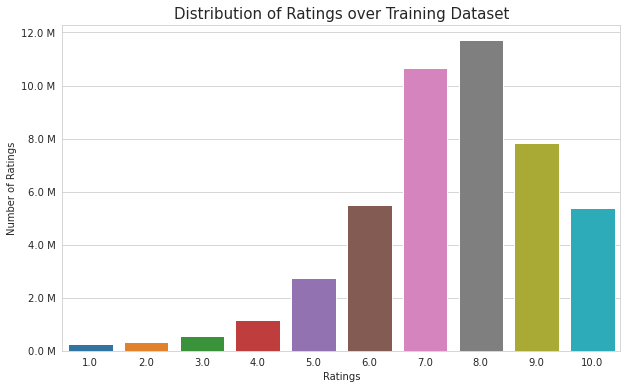

In [14]:
# Make the chart for numbers of ratings in Train Dataframe
fig, ax = plt.subplots(figsize = (10, 6))
plt.title('Distribution of Ratings over Training Dataset', fontsize=15)
sns.countplot(x = trainpd.rating)
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()

In [15]:
# Calculating maximum number of animes rated by a single user
import pyspark.sql.functions as F
no_of_rated_anime_per_user = train.groupBy('user_id').agg(F.count('*').alias('Frequency')).orderBy('Frequency',ascending=0)
no_of_rated_anime_per_user.show()
# From the below code cell, we can observe that the maximum number of animes rated by a single user as per our dataset is 12292

+-------+---------+
|user_id|Frequency|
+-------+---------+
| 189037|    12292|
| 162615|    11817|
|  68042|    10790|
| 283786|    10150|
| 259790|     8058|
| 291207|     7695|
| 182280|     7658|
| 277841|     7039|
| 336459|     6897|
|  10255|     6567|
| 312302|     6416|
| 328195|     6226|
| 300428|     5928|
| 276953|     5831|
| 190748|     5643|
| 345498|     5532|
|  64807|     5386|
|  85106|     5182|
| 122341|     5148|
| 299795|     4935|
+-------+---------+
only showing top 20 rows



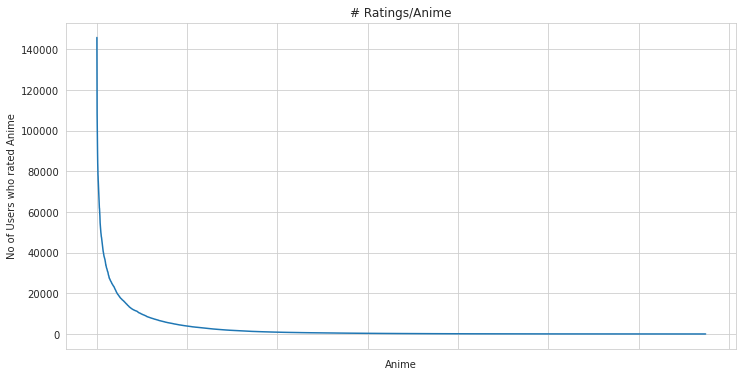

In [16]:
# Analysis of ratings of an anime given by a user

no_of_ratings_per_anime = trainpd.groupby(by='anime_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize = (12, 6))
ax = plt.gca()
plt.plot(no_of_ratings_per_anime.values)
plt.title('# Ratings/Anime')
plt.xlabel('Anime')
plt.ylabel('No of Users who rated Anime')
ax.set_xticklabels([])
plt.show()

# It is very skewed, just like the number of ratings given per user.
# There are some animes (which are very popular) which are rated by huge number of users.
# But most of the animes(like 90%) got some hundreds of ratings only.

In [17]:
# Import the required functions
# from pyspark.ml.recommendation import ALS
# Create ALS model for using with Cross Validator
# userCol is user_id, item Col is anime_id, ratingCol is rating in our ratings Dataframe,
# Set nonnegative is True because we are working with ratings greater than zero
# We have the rating values explicitly given by users so setting up implicitPrefs to False
# By default, Spark assigns NaN predictions during ALSModel.transform when a user and/or item factor is not present in the model.
# We set cold start strategy to ‘drop’ to ensure we don’t get NaN evaluation metrics
# als = ALS(
#          userCol="user_id", 
#          itemCol="anime_id",
#          ratingCol="rating", 
#          nonnegative = True, 
#          implicitPrefs = False,
#          coldStartStrategy="drop"
# )


In [18]:
# Import the required functions
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Defining Parameters using ParamGridBuilder
# Below values will results in  models
# param_grid = ParamGridBuilder().addGrid(als.rank, [5,10,20])\
#                                .addGrid(als.maxIter[5,50,150])
#                                 .addGrid(als.regParam, [0.1,0.01]).build()
# Build cross validation using CrossValidator
# estimater is the als model we created
# estimatortParamMaps is param_grid options created
# create evaluator, we are using rmse as evaluation function
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
# model = als.fit(train)

# Note: RMSE obtained from the above hyper-parameter tuning is 1.174163811242912 which we will be using in our next steps
# This code is being commented because of hardware shortage on our laptops to train number of models on entire dataset
# We will create new model with the best hyper-parameter values obtained from this step which is 
# maxIter=10
# regParam = 0.01,
# rank=50

In [19]:
# Create ALS Model without implementation of bias with the best parameter obtained using hyperparameter tuning
alsWithOutBias = ALS(maxIter=10, regParam = 0.01, userCol = "user_id",rank=50, itemCol = "anime_id", ratingCol = "rating", coldStartStrategy="drop")

In [20]:
# Train the model with train dataframe obtained after split
modelWithOutBias = alsWithOutBias.fit(train)

In [21]:
# Define evaluator as RMSE
evaluatorWithOutBias = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [22]:
# Get the predictions for the test data using the trained model
predictionsWithOutBias = modelWithOutBias.transform(test)


In [23]:
# Compute the RMSE by comparing rating and prediction values
RMSEWithOutBias = evaluatorWithOutBias.evaluate(predictionsWithOutBias)
print(RMSEWithOutBias)

1.1753068495143109


In [24]:
from pyspark.sql.functions import avg
## Calculating user-item interaction

# Calculate User Mean
userMeanDF = train.groupBy('user_id').agg({'rating': 'mean'}).withColumnRenamed("avg(rating)", "user_mean")

# Calculate Anime Mean
itemMeanDF = train.groupBy('anime_id').agg({'rating': 'mean'}).withColumnRenamed("avg(rating)", "item_mean")

# Calculate Global Average in Train set
globalAverageDF = train.select(avg('rating'))
globalAverage = globalAverageDF.collect()[0]['avg(rating)']

# Adding the mean columns to train DF
meanDF = train.join(userMeanDF, ['user_id'], "inner").join(itemMeanDF, ['anime_id'], "inner")

#create final DF with user-item interaction column
interactionDF = meanDF.withColumn('user_item_interaction', meanDF['rating']-(meanDF['user_mean'] + meanDF['item_mean'] - globalAverage))
interactionDF.show(5)

+--------+-------+------+-----------------+-----------------+---------------------+
|anime_id|user_id|rating|        user_mean|        item_mean|user_item_interaction|
+--------+-------+------+-----------------+-----------------+---------------------+
|   30654|    463|   7.0| 7.61864406779661|8.529941048712379|  -1.6378708920749325|
|    1829|    496|   5.0|            7.216|7.029735442023176|  -1.7350212175891189|
|    8086|    833|   9.0|7.851851851851852|7.701104746317513|   0.9577576262646907|
|    9465|    833|   7.0|7.851851851851852|7.943735171167099|   -1.284872798584896|
|   30654|   1088|   9.0|9.185185185185185|8.529941048712379|   -1.204412009463507|
+--------+-------+------+-----------------+-----------------+---------------------+
only showing top 5 rows



In [25]:
# Define new ALS model with ratings column as "user_item_interaction" 
als = ALS(maxIter=10, regParam = 0.01, userCol = "user_id",rank=50, itemCol = "anime_id", ratingCol = "user_item_interaction", coldStartStrategy="drop")

In [26]:
# Define evaluator as RMSE for the prediction in last step
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 

In [ ]:
# Train the model with biased values
model = als.fit(interactionDF)

In [ ]:
# Get the predictions from trained model
test_predictions = model.transform(test)
test_predictions.show(5)
# Predicitons are made by ALS model on user-item interaction column generated earlier

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
|     27|     245|   9.0| -0.741231|
|     27|     277|   9.0| 1.4521339|
|     27|     863|   8.0| 1.2890853|
|     27|    5114|   8.0|0.10490359|
|     27|   10589|   9.0| 0.8653243|
+-------+--------+------+----------+
only showing top 5 rows



In [ ]:
# This cell returns the RMSE of recommendations obtained using ALS + biases

# Adding Mean columns to predictions DataFrame
predictionsWithMean = test_predictions.join(userMeanDF, ['user_id'], "inner").join(itemMeanDF, ['anime_id'], "inner")


# Recomputing the predicted rating with the formula *rating +user_mean + item_mean- globalAverage rating
calculatedPredictionDF = predictionsWithMean.withColumn('prediction', predictionsWithMean['prediction'] +\
                                                            predictionsWithMean['user_mean'] + predictionsWithMean['item_mean'] - globalAverage)

print(calculatedPredictionDF.count())
# 'Prediction' Column contains predicted rating
calculatedPredictionDF.show(5)

# The RMSE compares the 'rating' (original rating) column and the 'predicition' (predicted rating) column
RMSE = evaluator.evaluate(calculatedPredictionDF)
print(RMSE)

11531950


+--------+-------+------+------------------+-----------------+-----------------+
|anime_id|user_id|rating|        prediction|        user_mean|        item_mean|
+--------+-------+------+------------------+-----------------+-----------------+
|      20|    148|  10.0|7.4117683142939095|7.443037974683544|7.787858606040424|
|     181|    148|   9.0| 7.939841626944671|7.443037974683544|7.541176470588235|
|    4437|    148|   8.0| 5.452700432666089|7.443037974683544|7.253777861730261|
|    4654|    148|   7.0| 6.413008330877088|7.443037974683544|7.608257951561132|
|    4752|    148|   7.0| 7.241840309069352|7.443037974683544|7.402285645180796|
+--------+-------+------+------------------+-----------------+-----------------+
only showing top 5 rows



1.1691393159883732


In [ ]:
# Generate top 5 movie recommendations for each user
nrecommendations = model.recommendForAllUsers(5)
nrecommendations.show()


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|     27|[{16007, 9.402412...|
|     28|[{23129, 7.471186...|
|     34|[{10627, 6.565496...|
|     44|[{8229, 5.762766}...|
|     53|[{38831, 6.592963...|
|     65|[{5548, 4.460235}...|
|     78|[{9165, 5.158185}...|
|     81|[{3923, 3.9401214...|
|     85|[{4933, 5.9871426...|
|    101|[{30105, 5.004441...|
|    103|[{6383, 10.278271...|
|    108|[{8229, 5.0485835...|
|    126|[{31501, 6.274219...|
|    133|[{38262, 10.95520...|
|    137|[{22345, 7.479967...|
|    148|[{6907, 7.8755937...|
|    155|[{3064, 4.4515033...|
|    192|[{5287, 5.979623}...|
|    193|[{11185, 6.443105...|
|    210|[{16371, 9.862499...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
# Exploding the 'recommendations' column containing anime_id and list of ratings of recommended animes to get rows with single recommendations
import pyspark.sql.functions as F
nrecommendations = nrecommendations.withColumn("rec_exp", F.explode("recommendations"))\
    .select('user_id', F.col("rec_exp.anime_id"), F.col("rec_exp.rating"))
nrecommendations.show()

+-------+--------+---------+
|user_id|anime_id|   rating|
+-------+--------+---------+
|     27|   16007| 9.402412|
|     27|   39020|9.2056875|
|     27|   42054| 8.915375|
|     27|   35135| 8.359258|
|     27|   13207| 8.235939|
|     28|   23129| 7.471186|
|     28|    6015|6.6924553|
|     28|    4497|6.4552903|
|     28|   36745| 5.714433|
|     28|    9254| 5.618196|
|     34|   10627|6.5654964|
|     34|   14537| 5.750683|
|     34|   33493| 5.688402|
|     34|   29956|5.6818132|
|     34|   39231|5.6666665|
|     44|    8229| 5.762766|
|     44|   34631|3.3578863|
|     44|   30105|3.3525047|
|     44|   40358|3.2648926|
|     44|    5201|3.2559705|
+-------+--------+---------+
only showing top 20 rows



In [ ]:
# Converting recommendations into readable format by adding anime name and genres
# Importing anime.csv which contains anime_id, Name and Genres
anime = spark.read.csv("gs://big_datat/anime.csv",header=True)
anime = anime.withColumn('MAL_ID', F.col('MAL_ID').cast('integer'))
anime = anime.withColumnRenamed('MAL_ID', 'anime_id')
anime = anime.select(F.col("anime_id"),F.col("Name"), F.col("Genres"))

In [34]:
# User’s ALS Recommendations:

# Joining recommended movies for the given user_id with anime dataframe to display recommendations in more readable format
nrecommendations.join(anime, on='anime_id').filter('user_id = 68042').show(truncate=False)

# User’s Actual Preference:
# Showing user's actual preference for comparison
ratings.join(anime, on='anime_id').filter('user_id = 68042').sort('rating', ascending=False).show(truncate=False)

+--------+-------+---------+---------------------------------+--------------------------------------------+
|anime_id|user_id|rating   |Name                             |Genres                                      |
+--------+-------+---------+---------------------------------+--------------------------------------------+
|9106    |68042  |7.4559608|Nogsaegjeoncha Hamos             |Action, Adventure, Fantasy, Shounen         |
|28347   |68042  |7.368685 |Guitar Shoujo!                   |Slice of Life                               |
|10202   |68042  |7.3120904|Kamen Rider Den-O: Imagin Anime 3|Action, Adventure, Comedy, Kids, Super Power|
|16608   |68042  |7.2097125|Shitcom                          |Comedy, Romance                             |
|29953   |68042  |7.1136403|Phantasm                         |Dementia, Music                             |
+--------+-------+---------+---------------------------------+--------------------------------------------+



+--------+-------+------+------------------------------------------+------------------------------------------------------------------------------------------+
|anime_id|user_id|rating|Name                                      |Genres                                                                                    |
+--------+-------+------+------------------------------------------+------------------------------------------------------------------------------------------+
|2251    |68042  |10.0  |Baccano!                                  |Action, Comedy, Historical, Mystery, Supernatural                                         |
|1535    |68042  |10.0  |Death Note                                |Mystery, Police, Psychological, Supernatural, Thriller, Shounen                           |
|47      |68042  |10.0  |Akira                                     |Action, Military, Sci-Fi, Adventure, Horror, Supernatural, Seinen                         |
|339     |68042  |10.0  |Serial Experime